
✅ K-Means Accuracy: 0.1062 | F1-score: 0.0881
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.14      0.15      0.15        13
           2       0.00      0.00      0.00         9
           3       1.00      0.18      0.31        11
           4       0.00      0.00      0.00         2
           5       0.31      0.71      0.43        17
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00         9
           9       0.00      0.00      0.00        12
          10       0.00      0.00      0.00        12
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         8
          14       0.25      0.08      0.12        12
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         1
          17       0.00      0.00 

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

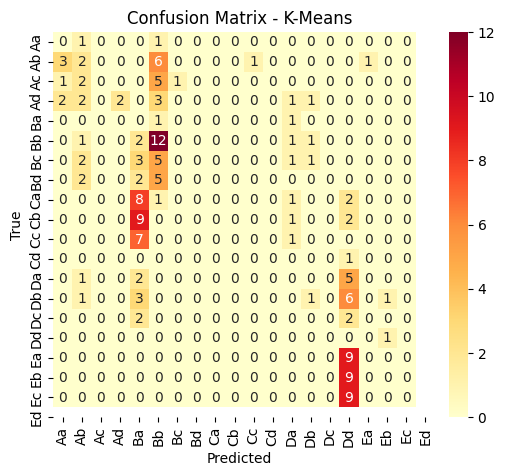


✅ Decision Tree Accuracy: 0.2437 | F1-score: 0.2352
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.18      0.15      0.17        13
           2       0.27      0.44      0.33         9
           3       0.33      0.27      0.30        11
           4       0.00      0.00      0.00         2
           5       0.36      0.29      0.32        17
           6       0.15      0.17      0.16        12
           7       0.10      0.11      0.11         9
           8       0.00      0.00      0.00         0
           9       0.20      0.17      0.18        12
          10       0.18      0.17      0.17        12
          11       0.20      0.25      0.22         8
          12       0.00      0.00      0.00         1
          13       0.28      0.62      0.38         8
          14       0.50      0.25      0.33        12
          15       0.00      0.00      0.00         4
          16       0.00     

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

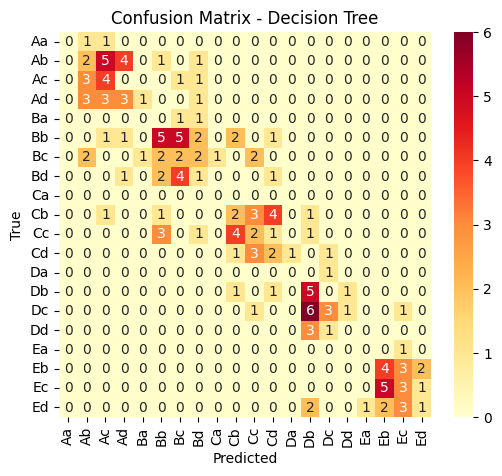


✅ KNN Accuracy: 0.3187 | F1-score: 0.2937
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.25      0.54      0.34        13
           2       0.00      0.00      0.00         9
           3       0.50      0.09      0.15        11
           4       0.00      0.00      0.00         2
           5       0.50      0.65      0.56        17
           6       0.23      0.25      0.24        12
           7       0.20      0.11      0.14         9
           9       0.29      0.42      0.34        12
          10       0.33      0.25      0.29        12
          11       0.33      0.25      0.29         8
          12       0.00      0.00      0.00         1
          13       0.44      0.50      0.47         8
          14       0.56      0.42      0.48        12
          15       0.33      0.25      0.29         4
          16       0.00      0.00      0.00         1
          17       0.29      0.56     

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

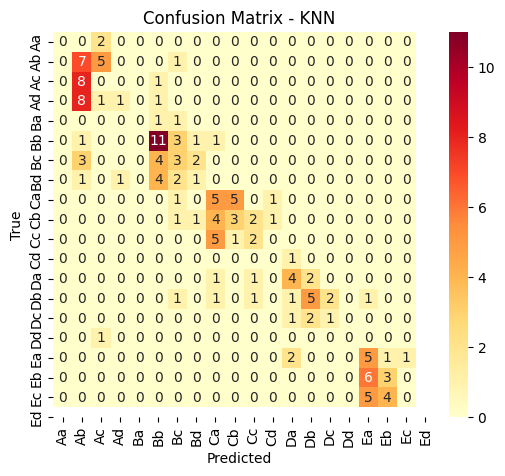

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

✅ ANN Accuracy: 0.3312 | F1-score: 0.2668
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.34      0.85      0.49        13
           2       0.17      0.11      0.13         9
           3       1.00      0.18      0.31        11
           4       0.00      0.00      0.00         2
           5       0.50      0.65      0.56        17
           6       0.30      0.25      0.27        12
           7       0.00      0.00      0.00         9
           9       0.33      0.67      0.44        12
          10       0.22      0.17      0.19        12
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         1
          13       0.25      0.50      0.33         8
          14       1.00      0.08      0.15        12
          15       0.20      0.25      0.22         4
          16       0.00      0.00      0.00         1


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

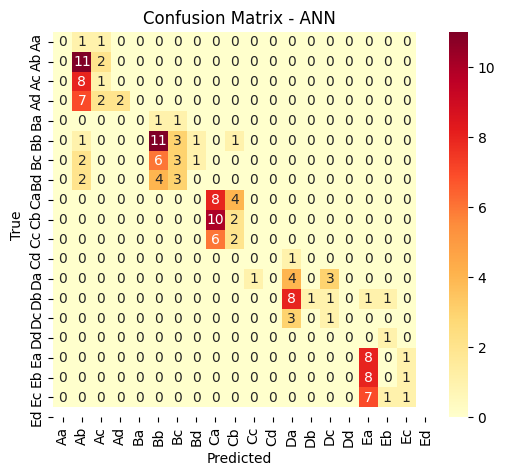

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

✅ Deep Learning Accuracy: 0.3500 | F1-score: 0.2507
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      1.00      0.50        13
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00         2
           5       0.50      0.65      0.56        17
           6       0.33      0.33      0.33        12
           7       0.00      0.00      0.00         9
           9       0.32      0.58      0.41        12
          10       0.33      0.25      0.29        12
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         1
          13       0.37      0.88      0.52         8
          14       0.50      0.17      0.25        12
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00 

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

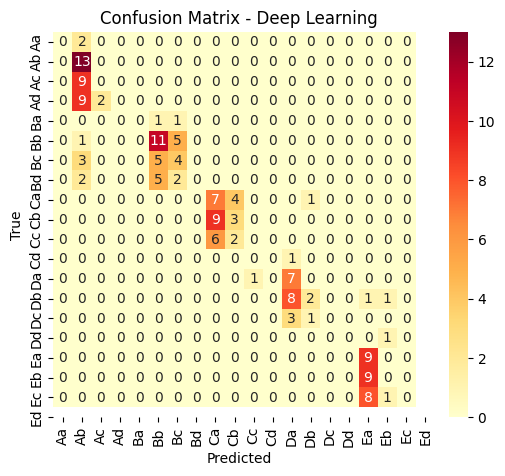


🎯 Summary Performance:
           Model  Accuracy        F1
0        K-Means   0.10625  0.088102
1  Decision Tree   0.24375  0.235162
2            KNN   0.31875  0.293743
3            ANN   0.33125  0.266794
4  Deep Learning   0.35000  0.250673

📊 ตัวอย่างผลลัพธ์ Deep Learning:
  True Label Predicted Label
0         Ac              Ab
1         Cc              Cb
2         Ed              Eb
3         Bd              Bb
4         Bc              Ab
5         Bb              Bb
6         Cd              Cc
7         Bc              Bc
8         Db              Db
9         Ab              Ab


In [3]:
# ✅ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scipy.optimize import linear_sum_assignment

# -----------------------------
# 1. Load & Prepare Data
# -----------------------------
df = pd.read_excel("stock_fun.xlsx")

# ✅ Remove unwanted columns
df = df.drop(columns=["score", "fundamental_groupvalue", "trend_grade"], errors='ignore')

# ✅ Remove missing rows
df = df.dropna()

# ✅ Split X, y
X = df.drop(columns=["quadrant"])
y = df["quadrant"]

# ✅ Keep only numeric features
X = X.select_dtypes(include=[np.number])

# ✅ Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ✅ Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# ✅ Helper: Evaluate Model
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"\n✅ {name} Accuracy: {acc:.4f} | F1-score: {f1:.4f}")
    print(classification_report(y_true, y_pred))
    return pd.DataFrame({"Model": [name], "Accuracy": [acc], "F1": [f1]})

# ✅ Helper: Plot Confusion Matrix
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

results = []

# -----------------------------
# 2. K-Means (Baseline)
# -----------------------------
kmeans = KMeans(n_clusters=len(np.unique(y_encoded)), random_state=42, n_init=10)
kmeans.fit(X_train)
y_pred_km = kmeans.predict(X_test)

# ✅ Map cluster → class with Hungarian algorithm
cont = confusion_matrix(y_test, y_pred_km)
# ✅ Hungarian algorithm mapping (robust version)
row_ind, col_ind = linear_sum_assignment(cont.max() - cont)
mapping = {col: row for row, col in zip(row_ind, col_ind)}

# ✅ แก้ KeyError: map เฉพาะ cluster ที่มีใน mapping
y_pred_km_mapped = np.array([mapping.get(c, 0) for c in y_pred_km])

results.append(evaluate_model("K-Means", y_test, y_pred_km_mapped))
plot_confusion(y_test, y_pred_km_mapped, "K-Means")

# -----------------------------
# 3. Decision Tree
# -----------------------------
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
results.append(evaluate_model("Decision Tree", y_test, y_pred_tree))
plot_confusion(y_test, y_pred_tree, "Decision Tree")

# -----------------------------
# 4. KNN
# -----------------------------
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
results.append(evaluate_model("KNN", y_test, y_pred_knn))
plot_confusion(y_test, y_pred_knn, "KNN")

# -----------------------------
# 5. ANN (Basic)
# -----------------------------
ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])
ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

y_pred_ann = np.argmax(ann.predict(X_test), axis=1)
results.append(evaluate_model("ANN", y_test, y_pred_ann))
plot_confusion(y_test, y_pred_ann, "ANN")

# -----------------------------
# 6. Deep Learning (Dropout)
# -----------------------------
deep = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])
deep.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
deep.fit(X_train, y_train, epochs=80, batch_size=16, verbose=0)

y_pred_deep = np.argmax(deep.predict(X_test), axis=1)
results.append(evaluate_model("Deep Learning", y_test, y_pred_deep))
plot_confusion(y_test, y_pred_deep, "Deep Learning")

# -----------------------------
# 7. Summary Results
# -----------------------------
df_summary = pd.concat(results, ignore_index=True)
print("\n🎯 Summary Performance:")
print(df_summary)

# -----------------------------
# 8. Compare True vs Predicted (Deep Learning)
# -----------------------------
df_compare = pd.DataFrame({
    "True Label": le.inverse_transform(y_test),
    "Predicted Label": le.inverse_transform(y_pred_deep)
})
print("\n📊 ตัวอย่างผลลัพธ์ Deep Learning:")
print(df_compare.head(10))


C:\Users\Admin\AppData\Local\Temp\ipykernel_2376\1280443075.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


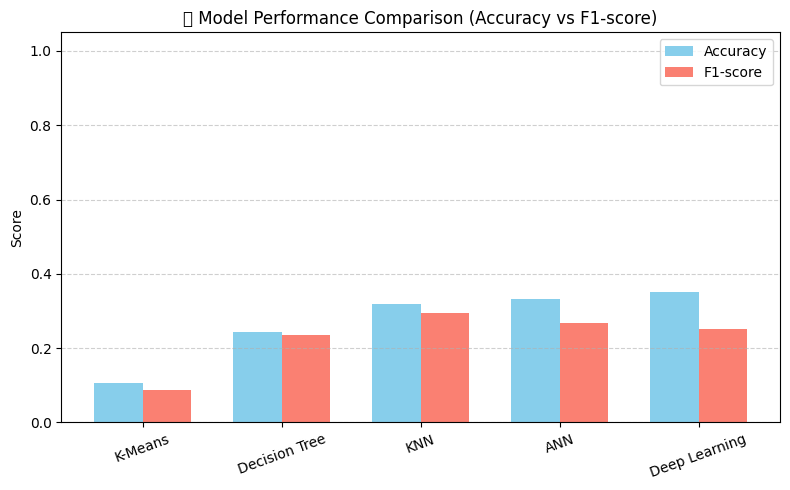

In [4]:
# -----------------------------
# 9. Plot Accuracy & F1 Comparison
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
bar_width = 0.35
x = np.arange(len(df_summary["Model"]))

# ✅ Plot bars
plt.bar(x - bar_width/2, df_summary["Accuracy"], width=bar_width, label="Accuracy", color="skyblue")
plt.bar(x + bar_width/2, df_summary["F1"], width=bar_width, label="F1-score", color="salmon")

# ✅ Labels and titles
plt.xticks(x, df_summary["Model"], rotation=20)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.title("📊 Model Performance Comparison (Accuracy vs F1-score)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [10]:
# ✅ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# --------------------------
# 1. โหลดข้อมูล
# --------------------------
df_fun = pd.read_excel("stock_fun_group.xlsx")

# ✅ เลือกเฉพาะคอลัมน์ที่ต้องใช้
features = ["eps", "pe", "pbv", "percentyield", "marketcap"]

# --------------------------
# 2. Standardization (Z-score)
# --------------------------
scaler = StandardScaler()
scaled = scaler.fit_transform(df_fun[features])
df_scaled = pd.DataFrame(scaled, columns=[f + "_scaled" for f in features], index=df_fun.index)

# --------------------------
# 3. สร้างคะแนนรวม (Score)
# --------------------------
df_fun["score"] = (
    df_scaled["eps_scaled"]            # + EPS
    - df_scaled["pe_scaled"]           # - PE
    + df_scaled["pbv_scaled"]          # + PBV
    + df_scaled["percentyield_scaled"] # + Dividend Yield
    + df_scaled["marketcap_scaled"]    # + Market Cap
)

# --------------------------
# 4. แบ่งออกเป็น 5 กลุ่ม (Quantile)
# --------------------------
df_fun["fundamental_group"] = pd.qcut(
    df_fun["score"],
    q=5,
    labels=["E", "D", "C", "B", "A"]  # E = อ่อนสุด → A = แข็งสุด
)

# --------------------------
# 5. เตรียมข้อมูลสำหรับ Deep Learning
# --------------------------
X = df_scaled.values
y = df_fun["fundamental_group"]

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# --------------------------
# 6. สร้างโมเดล Deep Learning
# --------------------------
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --------------------------
# 7. เทรนโมเดล
# --------------------------
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=0)

# --------------------------
# 8. ประเมินผล
# --------------------------
y_pred = np.argmax(model.predict(X_test), axis=1)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"\n✅ Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

✅ Accuracy: 0.9524 | F1-score: 0.9519


In [11]:
# ✅ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# --------------------------
# 1. Load Data
# --------------------------
df_candle = pd.read_excel("stock_june2025_onwards.xlsx")

# ตรวจสอบคอลัมน์หลัก
print("Columns:", df_candle.columns.tolist())

# --------------------------
# 2. ฟังก์ชันคำนวณ trend_grade
# --------------------------
def compute_technical_grades(df_candle, band_pct=0.015):
    df_result = []

    for symbol, df_sym in df_candle.groupby('symbol'):
        df_sym = df_sym.sort_values('time').copy()
        df_sym = df_sym.dropna(subset=['close_price'])

        if len(df_sym) < 50:
            continue

        # ✅ Indicators
        df_sym['ema5']   = df_sym['close_price'].ewm(span=5).mean()
        df_sym['ema15']  = df_sym['close_price'].ewm(span=15).mean()
        df_sym['ema35']  = df_sym['close_price'].ewm(span=35).mean()
        df_sym['ema89']  = df_sym['close_price'].ewm(span=89).mean()
        df_sym['ema200'] = df_sym['close_price'].ewm(span=200).mean()
        df_sym['rsi']    = ta.momentum.RSIIndicator(close=df_sym['close_price'], window=14).rsi()

        df_sym = df_sym.dropna(subset=['ema5','ema15','ema35','ema89','ema200','rsi'])
        if df_sym.empty:
            continue

        row = df_sym.iloc[-1]
        c, r = row['close_price'], row['rsi']
        e5, e15, e35, e89, e200 = row['ema5'], row['ema15'], row['ema35'], row['ema89'], row['ema200']

        if c >= e5 and r >= 70:
            grade = 'a'
        elif c >= e35 and e35 >= e89:
            grade = 'b'
        elif c >= e89 and (max([e5,e15,e35,e89]) - min([e5,e15,e35,e89])) / np.mean([e5,e15,e35,e89]) <= band_pct:
            grade = 'c'
        elif c < e89 and c < e200 and e89 < e200:
            grade = 'd'
        elif c < e5 < e15 < e35 < e89 < e200 and r <= 30:
            grade = 'e'
        else:
            grade = 'c'

        df_result.append({
            'symbol': symbol,
            'time': row['time'],
            'close_price': row['close_price'],
            'high_price': row['high_price'],
            'low_price': row['low_price'],
            'open_price': row['open_price'],
            'value': row['value'],
            'ema5': e5, 'ema15': e15, 'ema35': e35, 'ema89': e89, 'ema200': e200,
            'rsi': r, 'trend_grade': grade
        })

    return pd.DataFrame(df_result)

# --------------------------
# 3. คำนวณ Trend Grade
# --------------------------
df_trend = compute_technical_grades(df_candle)
print(f"✅ ได้ข้อมูลทั้งหมด {len(df_trend)} แถว")

# --------------------------
# 4. เตรียมข้อมูลเทรน Deep Learning
# --------------------------
features = ['close_price', 'high_price', 'low_price', 'open_price', 'value',
            'ema5','ema15','ema35','ema89','ema200','rsi']

X = df_trend[features]
y = df_trend['trend_grade']

# ✅ Encode labels (a–e)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ✅ Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# --------------------------
# 5. Deep Learning Model
# --------------------------
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --------------------------
# 6. Train Model
# --------------------------
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=0)

# --------------------------
# 7. Evaluate
# --------------------------
y_pred = np.argmax(model.predict(X_test), axis=1)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n✅ Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

Columns: ['symbol', 'time', 'close_price', 'high_price', 'low_price', 'open_price', 'value', 'volume']
✅ ได้ข้อมูลทั้งหมด 856 แถว


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

✅ Accuracy: 0.7093 | F1-score: 0.6563


In [12]:
# ✅ Import Libraries
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. โหลด Fundamental Data
# --------------------------
df_fun = pd.read_excel("stock_fun_group.xlsx")[["symbol", "eps", "pe", "pbv", "percentyield", "marketcap", "fundamental_group"]]

# --------------------------
# 2. โหลด Candle Data แล้วสร้าง trend_grade
# --------------------------
df_candle = pd.read_excel("stock_june2025_onwards.xlsx")

def compute_technical_grades(df_candle, band_pct=0.015):
    df_result = []
    for symbol, df_sym in df_candle.groupby('symbol'):
        df_sym = df_sym.sort_values('time').copy()
        df_sym = df_sym.dropna(subset=['close_price'])
        if len(df_sym) < 50:
            continue
        df_sym['ema5']   = df_sym['close_price'].ewm(span=5).mean()
        df_sym['ema15']  = df_sym['close_price'].ewm(span=15).mean()
        df_sym['ema35']  = df_sym['close_price'].ewm(span=35).mean()
        df_sym['ema89']  = df_sym['close_price'].ewm(span=89).mean()
        df_sym['ema200'] = df_sym['close_price'].ewm(span=200).mean()
        df_sym['rsi']    = ta.momentum.RSIIndicator(close=df_sym['close_price'], window=14).rsi()
        df_sym = df_sym.dropna(subset=['ema5','ema15','ema35','ema89','ema200','rsi'])
        if df_sym.empty:
            continue
        row = df_sym.iloc[-1]
        c, r = row['close_price'], row['rsi']
        e5, e15, e35, e89, e200 = row['ema5'], row['ema15'], row['ema35'], row['ema89'], row['ema200']
        if c >= e5 and r >= 70:
            grade = 'a'
        elif c >= e35 and e35 >= e89:
            grade = 'b'
        elif c >= e89 and (max([e5,e15,e35,e89]) - min([e5,e15,e35,e89])) / np.mean([e5,e15,e35,e89]) <= band_pct:
            grade = 'c'
        elif c < e89 and c < e200 and e89 < e200:
            grade = 'd'
        elif c < e5 < e15 < e35 < e89 < e200 and r <= 30:
            grade = 'e'
        else:
            grade = 'c'

        df_result.append({
            'symbol': symbol,
            'close_price': row['close_price'],
            'high_price': row['high_price'],
            'low_price': row['low_price'],
            'open_price': row['open_price'],
            'value': row['value'],
            'ema5': e5, 'ema15': e15, 'ema35': e35, 'ema89': e89, 'ema200': e200,
            'rsi': r, 'trend_grade': grade
        })
    return pd.DataFrame(df_result)

df_trend = compute_technical_grades(df_candle)
print(f"✅ Fundamental data: {df_fun.shape[0]} rows | Technical data: {df_trend.shape[0]} rows")

# --------------------------
# 3. รวมสองชุดข้อมูลด้วย symbol
# --------------------------
df_merge = pd.merge(df_fun, df_trend, on="symbol", how="inner")
print(f"✅ รวมข้อมูลได้ทั้งหมด {len(df_merge)} แถว")

✅ Fundamental data: 836 rows | Technical data: 856 rows
✅ รวมข้อมูลได้ทั้งหมด 799 แถว


In [13]:

# --------------------------
# 4. สร้าง Quadrant
# --------------------------
df_merge["quadrant"] = df_merge["fundamental_group"].astype(str) + df_merge["trend_grade"].astype(str)
print("ตัวอย่าง Quadrant:\n", df_merge[["symbol", "fundamental_group", "trend_grade", "quadrant"]].head())

ตัวอย่าง Quadrant:
   symbol fundamental_group trend_grade quadrant
0   PPPM                 D           d       Dd
1   TPCH                 A           c       Ac
2   POLY                 A           c       Ac
3   VCOM                 A           b       Ab
4    NVD                 E           d       Ed


In [17]:
df_merge.head()

,symbol,eps,pe,pbv,percentyield,marketcap,fundamental_group,close_price,high_price,low_price,open_price,value,ema5,ema15,ema35,ema89,ema200,rsi,trend_grade,quadrant
0,PPPM,0.02000,0.00,0.70,0.00,105500.001572,D,0.40,0.43,0.39,0.42,0,0.405345,0.413705,0.419833,0.428406,0.434019,40.720717,d,Dd
1,TPCH,0.24112,7.90,0.34,13.91,401575.987864,A,2.84,2.90,2.84,2.86,0,2.844297,2.849749,2.849346,2.849244,2.848840,47.825269,c,Ac
2,POLY,0.27632,12.89,2.42,6.38,152320.004272,A,6.80,7.05,6.80,6.90,0,6.829600,6.925563,6.948069,6.916856,6.896954,44.452126,c,Ac
3,VCOM,0.21428,7.85,1.48,10.79,303722.809988,A,2.90,2.94,2.90,2.92,0,2.899084,2.905416,2.884641,2.827082,2.789608,50.733075,b,Ab
4,NVD,-0.00942,38.87,0.32,0.00,4186.000121,E,0.91,0.93,0.91,0.93,0,0.924915,0.929716,0.935469,0.947964,0.955180,43.396960,d,Ed


In [14]:
# --------------------------
# 5. เตรียมฟีเจอร์และ label
# --------------------------
features = ["eps", "pe", "pbv", "percentyield", "marketcap",
            "close_price", "high_price", "low_price", "open_price",
            "value", "ema5", "ema15", "ema35", "ema89", "ema200", "rsi"]

X = df_merge[features]
y = df_merge["quadrant"]

# --------------------------
# 6. Encode target & Scale features
# --------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------
# 7. Split Train/Test
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# --------------------------
# 8. สร้างโมเดล Deep Learning
# --------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --------------------------
# 9. เทรนโมเดล
# --------------------------
history = model.fit(X_train, y_train, epochs=120, batch_size=16, validation_split=0.1, verbose=0)

# --------------------------
# 10. ประเมินผลลัพธ์
# --------------------------
y_pred = np.argmax(model.predict(X_test), axis=1)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"\n✅ Accuracy: {acc:.4f} | F1-score: {f1:.4f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

✅ Accuracy: 0.6250 | F1-score: 0.6233
              precision    recall  f1-score   support

          Aa       0.00      0.00      0.00         2
          Ab       0.65      0.85      0.73        13
          Ac       0.57      0.89      0.70         9
          Ad       1.00      0.55      0.71        11
          Ba       1.00      1.00      1.00         2
          Bb       0.81      0.76      0.79        17
          Bc       0.50      0.42      0.45        12
          Bd       0.38      0.56      0.45         9
          Ca       0.00      0.00      0.00         0
          Cb       1.00      0.58      0.74        12
          Cc       0.73      0.67      0.70        12
          Cd       0.40      0.50      0.44         8
          Da       1.00      1.00      1.00         1
          Db       0.75      0.75      0.75         8
          Dc       0.70      0.58      0.64        12
          Dd       0.20      0.25      0.22         4
    

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

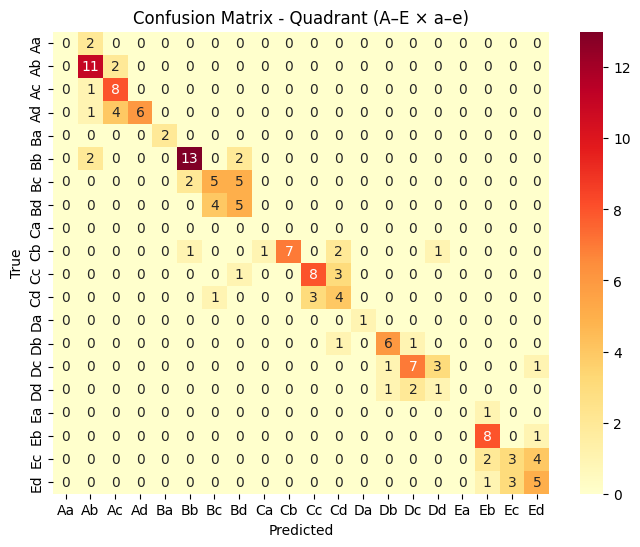

In [15]:
# --------------------------
# 11. Confusion Matrix
# --------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Quadrant (A–E × a–e)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

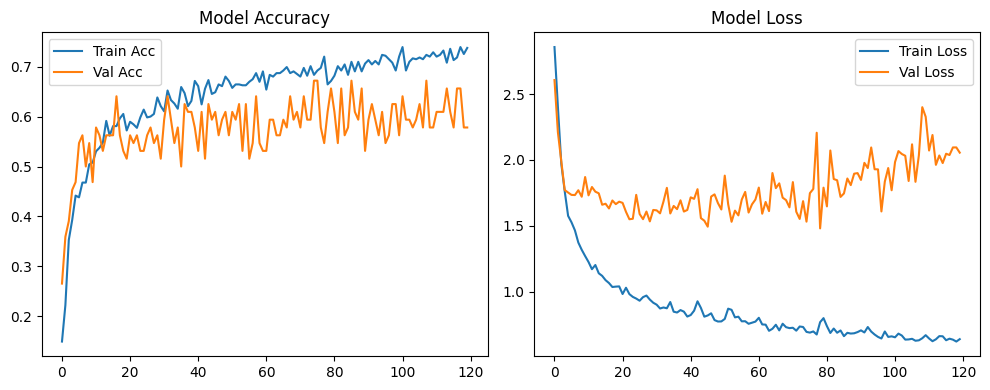

In [16]:
# --------------------------
# 12. Plot Accuracy & Loss
# --------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.legend()
plt.tight_layout()
plt.show()